In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import re
import os

import json
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

os.getcwd()

## Important faults: 55\- AC CONTACTOR  67\-BUS DIFF VOL 95\-DC\-FUSE



### Read data from module\_RR.pkl and use sliding window to generate train and test data



read data

In [23]:
path = '../Multilabel_classification/Data/module_RR.pkl'
file_name = path
f = open(file_name, 'rb')
data = pickle.load(f)
print(len(data))
X = data['data']
print('X shape:',X.shape)
Y = data['label']
print('Y shape:',Y.shape)
README = data['README']
print(README)

3
X shape: (20, 10, 5, 70176)
Y shape: (20, 10, 70176)
Red Rock time series data---Y: Module level fault codes X1 x2: module level Tinv and Tigbt; x3: model level status, X4 x5: module level Tinv difference and Tigbt difference compared with average data


sliding window

### 2.1 Faults classes check



*******label and counts of original Y
[ 0.  1.  4.  5. 12. 13. 14. 15. 16. 18. 19. 20. 21. 26. 36. 40. 41. 42.
 48. 50. 53. 55. 61. 62. 65. 67. 83. 84. 85. 86. 95.] [13791735     2825     4651     1377     5861       10     4345      950
      205    14415     6210       48      785      333     7312    27346
     3904     8660      402      635    13459    31765      557      688
      206    48783     1675      135     4139    20996    30788]


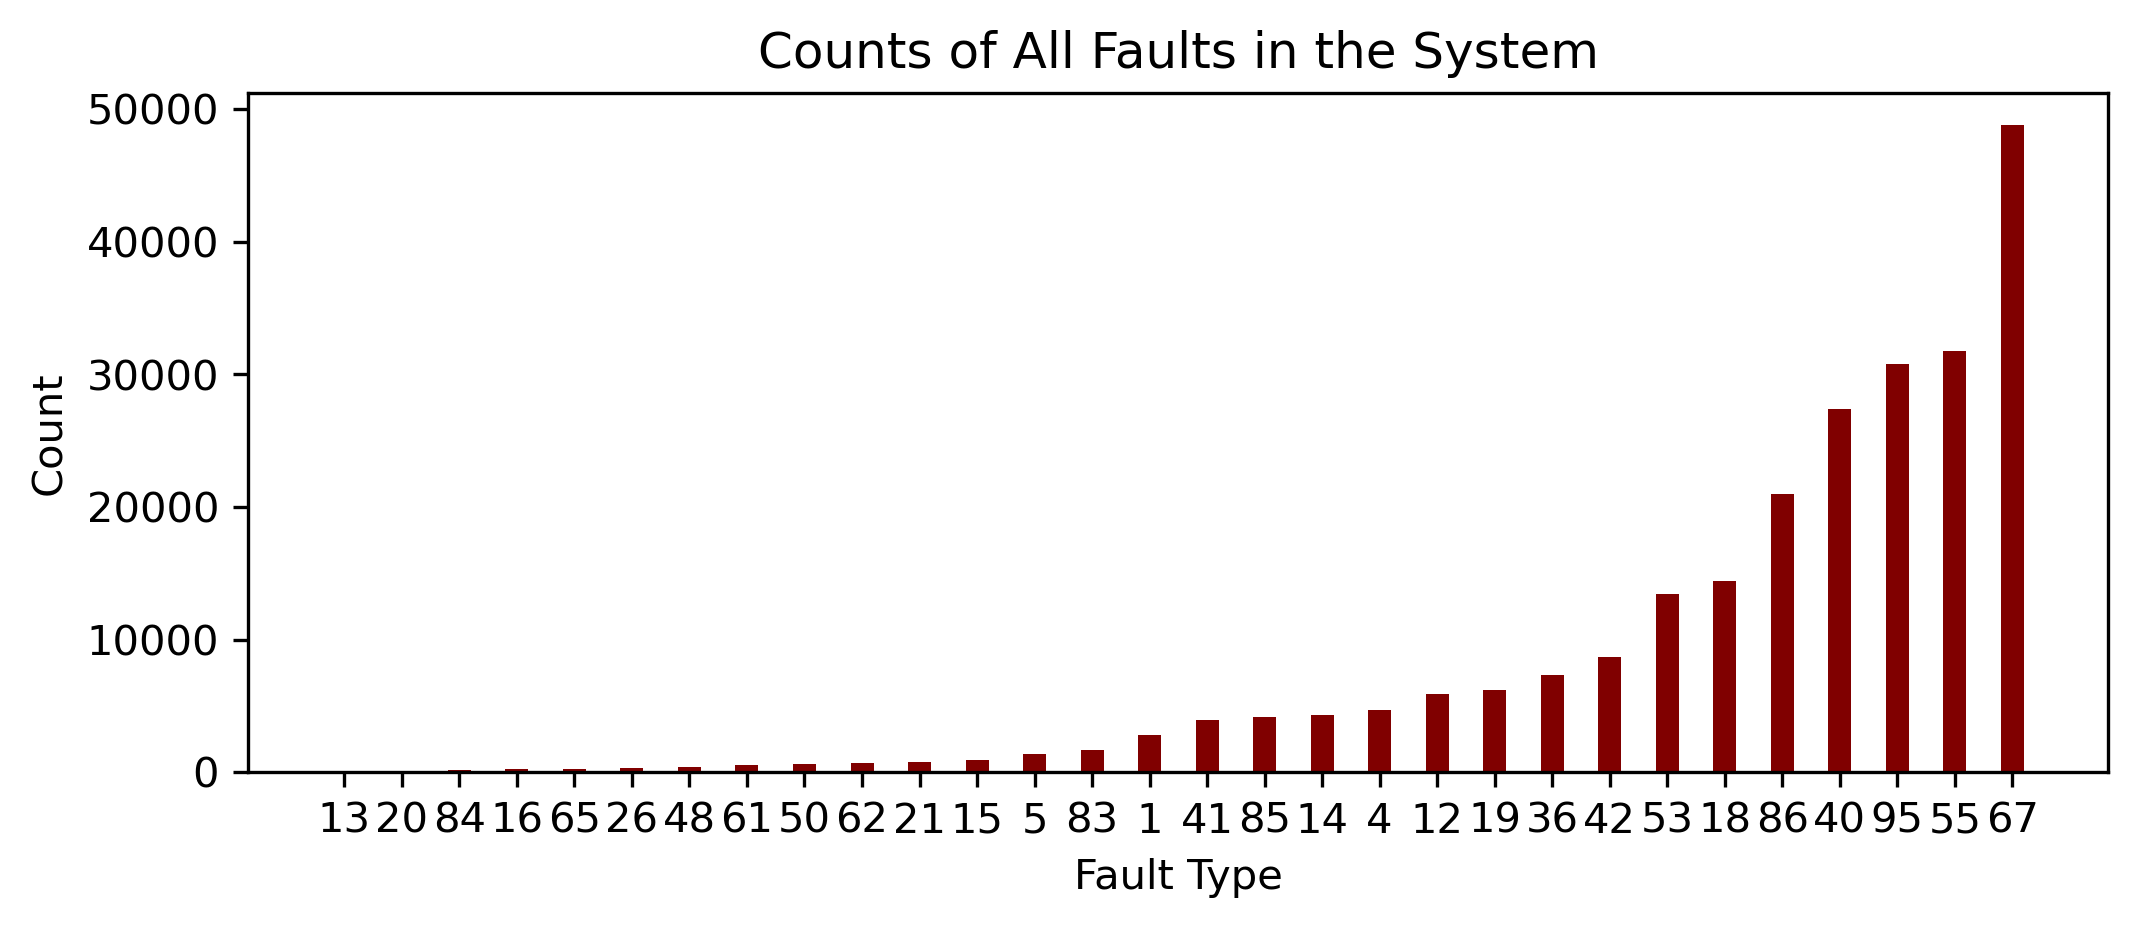

In [24]:
def fault_check(labels):
    unique_fault, counts = np.unique(labels, return_counts=True)
    df = pd.DataFrame({'event':unique_fault, 'count':counts}).drop(0).sort_values(by=['count'])
    print("*******label and counts of original Y")
    print(unique_fault, counts)
    return df

p = '../Multilabel_classification/Data'
df_counts = fault_check(Y)
plt.figure(figsize=(8, 3), dpi=300)
df_counts["event"] = df_counts["event"].astype(int).astype(str)
df_counts.to_csv(Path(p,'countsRR_TS.csv'),index = False)
plt.bar(df_counts['event'].to_list(), df_counts['count'].to_list(), color ='maroon',
        width = 0.4)
plt.title('Counts of All Faults in the System')
plt.xlabel("Fault Type")
plt.ylabel("Count")
plt.savefig(Path(p,'countsRR_TS.png'), bbox_inches='tight')
plt.show()


In [25]:
from sklearn import preprocessing

unique_fault, counts = np.unique(Y, return_counts=True)
print("*******label and counts of original Y")
unique_fault = unique_fault.tolist()
print(unique_fault, counts)
#only keep three faults
useful_code = [0.0, 55.0, 67.0, 95.0]
rare_list = [x for x in unique_fault if x not in useful_code]
rare_list = np.array(rare_list)
# rare_list = unique_fault[counts<8000]   # 9 for 8000; 6 for 20000
print('....',rare_list.shape)
precess_Y = Y.copy()
for rare_value in rare_list:
    precess_Y[precess_Y == rare_value] = 100   #assign another value to the 100
unique_fault1, counts1 = np.unique(precess_Y, return_counts=True)
print("*******label and counts after filter")
print(unique_fault1, counts1)

le = preprocessing.LabelEncoder()
shape_Y = precess_Y.shape
Y_le = le.fit_transform(precess_Y.flatten('C'))
Y_le = Y_le.reshape(shape_Y,order='C')   #Y lable after label embeding
Yshape = Y_le.shape
Y_reshape = Y_le.reshape((Yshape[0]*Yshape[1],Yshape[2]))
Y_reshape = np.swapaxes(Y_reshape,1,0)

*******label and counts of original Y
[0.0, 1.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 19.0, 20.0, 21.0, 26.0, 36.0, 40.0, 41.0, 42.0, 48.0, 50.0, 53.0, 55.0, 61.0, 62.0, 65.0, 67.0, 83.0, 84.0, 85.0, 86.0, 95.0] [13791735     2825     4651     1377     5861       10     4345      950
      205    14415     6210       48      785      333     7312    27346
     3904     8660      402      635    13459    31765      557      688
      206    48783     1675      135     4139    20996    30788]
.... (27,)


*******label and counts after filter
[  0.  55.  67.  95. 100.] [13791735    31765    48783    30788   132129]


In [26]:
Xshape = X.shape
X_reshape = X.reshape((Xshape[0]*Xshape[1],Xshape[2],Xshape[3]))
X_reshape = np.swapaxes(X_reshape,2,0)
X_reshape = np.swapaxes(X_reshape,2,1)[...,:-1]

In [29]:
print(X_reshape.shape,Y_reshape.shape)

(70176, 200, 4) (70176, 200)


### 2.2 Sliding window and train\-test\-split



In [30]:
stride=30 #timestamps
sequence_length=100 #timestamps
forecast_length=100  #timestamps

def sliding_windows(X,Y,stride,sequence_length,forecast_length):   #x and y have the same time steps
    x = []
    y = []
    forecast_y=[]
    for i in range(int((len(X)-sequence_length)/stride)+1-stride): 
        _x = X[i*stride:i*stride+sequence_length,...]
        _y = Y[i*stride:i*stride+sequence_length,...]
        if i<=(int((len(X)-sequence_length)/stride)+1)-stride-1:
            _f = Y[i*stride+sequence_length:i*stride+sequence_length+forecast_length,...]
            forecast_y.append(_f)
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y),np.array(forecast_y)


Min_max   = MinMaxScaler()
X_norm    = X_reshape.reshape(-1,1)
X_norm    = Min_max.fit_transform(X_norm)
X_norm    = X_norm.reshape(X_reshape.shape)
train_len = int(np.floor(len(Y_reshape)/10*0.8)*10)-60
test_len  = int(np.floor(len(Y_reshape)/10*0.2)*10)-40
train_X   = X_norm[:train_len,:]
train_Y   = Y_reshape[:train_len]
test_X    = X_norm[train_len:train_len+test_len,:]
test_Y    = Y_reshape[train_len:train_len+test_len]


train_X_win, train_Y_win, train_f_y = sliding_windows(train_X,train_Y,stride,sequence_length,forecast_length)
test_X_win , test_Y_win , test_f_y  = sliding_windows(test_X,test_Y,stride,sequence_length,forecast_length)
print('Shape of traning X, Y forecast:',train_X_win.shape,train_Y_win.shape,train_f_y.shape)
print('Shape of test X, Y forecast:',   test_X_win.shape,test_Y_win.shape,test_f_y.shape)


Shape of traning X, Y forecast: (1837, 100, 200, 4) (1837, 100, 200) (1837, 100, 200)
Shape of test X, Y forecast: (434, 100, 200, 4) (434, 100, 200) (434, 100, 200)


Put all inverter and modules data in the first dimension

In [31]:
def All_Module_to_One(X,Y): 
    X      = np.swapaxes(X,1,2)
    Xshape = X.shape
    X      = X.reshape((Xshape[0]*Xshape[1],Xshape[2],Xshape[3]))
    Y      = np.swapaxes(Y,1,2)
    Yshape = Y.shape
    Y      = Y.reshape((Yshape[0]*Yshape[1],Yshape[2]))
    print('shapes of X and Y:',X.shape,Y.shape)
    return X, Y

train_X, train_Y = All_Module_to_One(train_X_win, train_Y_win)
test_X ,test_Y   = All_Module_to_One(test_X_win, test_Y_win)




shapes of X and Y: (367400, 100, 4) (367400, 100)
shapes of X and Y: (86800, 100, 4) (86800, 100)


In [32]:
#convert y labels to multip label

def multievent(labels): 
    one_hot      = MultiLabelBinarizer()
    y_multilabel = one_hot.fit_transform(labels)
    y_multi      = y_multilabel[:,1:]  #Only keep only fault columns
    print('Size of new generated labels:',y_multi.shape)
    return y_multi

train_multi = multievent(train_Y)
test_multi  = multievent(test_Y)
    # print('If there is any multi-labels:',2 in np.sum(y_multilabel,axis=1))


Size of new generated labels: (367400, 4)


Size of new generated labels: (86800, 4)


In [33]:
summation  = test_multi.sum(1)
summation_train = train_multi.sum(1)
num_nonzero = list(summation_train).count(0)
num_nonzero = len(summation_train) - num_nonzero
print(num_nonzero)  #
num_nonzero = list(summation).count(0)
num_nonzero = len(summation) - num_nonzero
print(num_nonzero)  #

9882
1501


In [34]:
print(np.unique(train_Y))
a = np.array([ 0,  1,  2,  3,4])
reverse_label = le.inverse_transform(a)
print(reverse_label)

[0 1 2 3 4]
[  0.  55.  67.  95. 100.]


## set device and torchdataset

In [35]:
import torch.utils.data as data_utils
device='cuda:3'
BS=40
train_data=data_utils.TensorDataset(torch.Tensor(train_X).float().to(device),torch.Tensor(train_multi).float().to(device))
train_data_loader = torch.utils.data.DataLoader(train_data,batch_size =BS,shuffle=True)
test_data=data_utils.TensorDataset(torch.Tensor(test_X).float().to(device),torch.Tensor(test_multi).float().to(device))
test_data_loader = torch.utils.data.DataLoader(test_data,batch_size =10000)

# CNN



In [79]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=64,    # n_filters
                kernel_size=(5,2),      # filter size
                stride=2,           # filter movement/step
                padding=1,
            ),     
            nn.MaxPool2d(kernel_size=2),   
        )
        self.conv2 = nn.Sequential(  
            nn.Conv2d(64, 32, (5,2), 1, 1),  
#             nn.ReLU(),  # activation
            nn.MaxPool2d(2), 
        )
        self.out = nn.Linear(352 , 4)
#         self.out2 = nn.Linear(32 , 4)   # fully connected layer, output 5 classes

    def forward(self, x):
        x = self.conv1(x)
        # print('1:',x.shape)
        x = self.conv2(x)
        # print('2:',x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        output = self.out(x)
        return output



In [80]:
EPOCH     = 150
cnn       = CNN().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0002)  
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5]).to(device))

for epoch in range(EPOCH): 
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.05/(epoch+1))  
    train_loss = []
    for step, (b_x, b_y) in enumerate(train_data_loader):
        output = cnn(b_x.unsqueeze(1))                  # cnn output
        loss   = loss_func(output, b_y)                 # loss
        train_loss.append(loss)
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
    avg_loss = sum(train_loss)/len(train_data_loader)

    print('Epoch: ',epoch,' loss: ',avg_loss)

Epoch:  0  loss:  tensor(12.7842, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  1  loss:  tensor(2.4038, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  2  loss:  tensor(0.5324, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  3  loss:  tensor(0.1974, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  4  loss:  tensor(0.1292, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  5  loss:  tensor(0.0727, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  6  loss:  tensor(0.0577, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  7  loss:  tensor(0.0473, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  8  loss:  tensor(0.0451, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  9  loss:  tensor(0.0434, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  10  loss:  tensor(0.0434, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  11  loss:  tensor(0.0421, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  12  loss:  tensor(0.0399, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  13  loss:  tensor(0.0391, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  14  loss:  tensor(0.0385, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  15  loss:  tensor(0.0377, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  16  loss:  tensor(0.0372, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  17  loss:  tensor(0.0362, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  18  loss:  tensor(0.0358, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  19  loss:  tensor(0.0355, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  20  loss:  tensor(0.0350, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  21  loss:  tensor(0.0345, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  22  loss:  tensor(0.0340, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  23  loss:  tensor(0.0336, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  24  loss:  tensor(0.0331, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  25  loss:  tensor(0.0327, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  26  loss:  tensor(0.0325, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  27  loss:  tensor(0.0321, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  28  loss:  tensor(0.0319, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  29  loss:  tensor(0.0315, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  30  loss:  tensor(0.0312, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  31  loss:  tensor(0.0308, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  32  loss:  tensor(0.0306, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  33  loss:  tensor(0.0302, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  34  loss:  tensor(0.0301, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  35  loss:  tensor(0.0299, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  36  loss:  tensor(0.0295, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  37  loss:  tensor(0.0294, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  38  loss:  tensor(0.0292, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  39  loss:  tensor(0.0290, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  40  loss:  tensor(0.0288, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  41  loss:  tensor(0.0285, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  42  loss:  tensor(0.0284, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  43  loss:  tensor(0.0283, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  44  loss:  tensor(0.0281, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  45  loss:  tensor(0.0279, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  46  loss:  tensor(0.0278, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  47  loss:  tensor(0.0275, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  48  loss:  tensor(0.0275, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  49  loss:  tensor(0.0273, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  50  loss:  tensor(0.0271, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  51  loss:  tensor(0.0271, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  52  loss:  tensor(0.0269, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  53  loss:  tensor(0.0268, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  54  loss:  tensor(0.0266, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  55  loss:  tensor(0.0265, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  56  loss:  tensor(0.0264, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  57  loss:  tensor(0.0263, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  58  loss:  tensor(0.0263, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  59  loss:  tensor(0.0262, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  60  loss:  tensor(0.0258, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  61  loss:  tensor(0.0260, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  62  loss:  tensor(0.0258, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  63  loss:  tensor(0.0257, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  64  loss:  tensor(0.0256, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  65  loss:  tensor(0.0255, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  66  loss:  tensor(0.0254, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  67  loss:  tensor(0.0254, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  68  loss:  tensor(0.0253, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  69  loss:  tensor(0.0252, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  70  loss:  tensor(0.0251, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  71  loss:  tensor(0.0251, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  72  loss:  tensor(0.0250, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  73  loss:  tensor(0.0248, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  74  loss:  tensor(0.0249, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  75  loss:  tensor(0.0247, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  76  loss:  tensor(0.0246, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  77  loss:  tensor(0.0246, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  78  loss:  tensor(0.0246, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  79  loss:  tensor(0.0245, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  80  loss:  tensor(0.0243, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  81  loss:  tensor(0.0244, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  82  loss:  tensor(0.0243, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  83  loss:  tensor(0.0242, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  84  loss:  tensor(0.0241, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  85  loss:  tensor(0.0241, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  86  loss:  tensor(0.0240, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  87  loss:  tensor(0.0240, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  88  loss:  tensor(0.0239, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  89  loss:  tensor(0.0239, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  90  loss:  tensor(0.0238, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  91  loss:  tensor(0.0237, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  92  loss:  tensor(0.0237, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  93  loss:  tensor(0.0236, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  94  loss:  tensor(0.0236, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  95  loss:  tensor(0.0234, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  96  loss:  tensor(0.0234, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  97  loss:  tensor(0.0234, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  98  loss:  tensor(0.0233, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  99  loss:  tensor(0.0233, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  100  loss:  tensor(0.0231, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  101  loss:  tensor(0.0231, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  102  loss:  tensor(0.0232, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  103  loss:  tensor(0.0231, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  104  loss:  tensor(0.0231, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  105  loss:  tensor(0.0230, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  106  loss:  tensor(0.0230, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  107  loss:  tensor(0.0229, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  108  loss:  tensor(0.0229, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  109  loss:  tensor(0.0228, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  110  loss:  tensor(0.0228, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  111  loss:  tensor(0.0227, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  112  loss:  tensor(0.0227, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  113  loss:  tensor(0.0226, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  114  loss:  tensor(0.0226, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  115  loss:  tensor(0.0226, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  116  loss:  tensor(0.0226, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  117  loss:  tensor(0.0225, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  118  loss:  tensor(0.0224, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  119  loss:  tensor(0.0224, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  120  loss:  tensor(0.0223, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  121  loss:  tensor(0.0223, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  122  loss:  tensor(0.0223, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  123  loss:  tensor(0.0222, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  124  loss:  tensor(0.0222, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  125  loss:  tensor(0.0221, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  126  loss:  tensor(0.0221, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  127  loss:  tensor(0.0220, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  128  loss:  tensor(0.0221, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  129  loss:  tensor(0.0220, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  130  loss:  tensor(0.0220, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  131  loss:  tensor(0.0219, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  132  loss:  tensor(0.0219, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  133  loss:  tensor(0.0219, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  134  loss:  tensor(0.0218, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  135  loss:  tensor(0.0218, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  136  loss:  tensor(0.0218, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  137  loss:  tensor(0.0217, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  138  loss:  tensor(0.0218, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  139  loss:  tensor(0.0217, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  140  loss:  tensor(0.0216, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  141  loss:  tensor(0.0216, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  142  loss:  tensor(0.0216, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  143  loss:  tensor(0.0216, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  144  loss:  tensor(0.0215, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  145  loss:  tensor(0.0215, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  146  loss:  tensor(0.0214, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  147  loss:  tensor(0.0215, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  148  loss:  tensor(0.0214, device='cuda:3', grad_fn=<DivBackward0>)


Epoch:  149  loss:  tensor(0.0214, device='cuda:3', grad_fn=<DivBackward0>)


### save trained model



In [81]:
save_path = '../Multilabel_classification/saved_models/rr_imp_detection_556795_w5.pth'
torch.save(cnn.state_dict(), save_path)

In [84]:
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5]).to(device))

path = '../Multilabel_classification/saved_models/rr_imp_detection_556795_w5.pth'
cnn = CNN()
cnn.load_state_dict(torch.load(path))
cnn.eval()
cnn.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 2), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(5, 2), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=352, out_features=4, bias=True)
)

### Define test



In [85]:
batch_size = 10000
def test(net,testloader):

    test_loss=0.0
    test_results =torch.zeros_like(torch.tensor(test_multi))
    net.eval()
    test_loss=0.0
    for i, (data, target) in enumerate(testloader):
        print(data.shape)
        output = net(data.unsqueeze(1))
#         print(output.shape)
        # calculate the loss
        loss = loss_func(output, target)
        # update running validation loss
        test_loss += loss.item()*data.size(0)
        if data.size(0)==batch_size:
            test_results[batch_size*i:batch_size*(i+1)]=output.squeeze()
        else:
            test_results[batch_size*i:]=output.squeeze()
    test_loss_avg = test_loss/len(testloader.sampler)
    print('loss: ',test_loss_avg)
    return test_loss_avg, test_results


In [86]:
test_loss, prediction = test(cnn,test_data_loader)

torch.Size([10000, 100, 4])
torch.Size([10000, 100, 4])


torch.Size([10000, 100, 4])
torch.Size([10000, 100, 4])
torch.Size([10000, 100, 4])


torch.Size([10000, 100, 4])


torch.Size([10000, 100, 4])
torch.Size([10000, 100, 4])
torch.Size([6800, 100, 4])
loss:  0.03780544076913169


In [87]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

torch.Size([86800, 4])
[[86202    89]
 [  393   116]]
F1 score: 0.3249299719887955
[[86300   262]
 [   59   179]]
F1 score: 0.5272459499263623
[[86677    50]
 [   27    46]]
F1 score: 0.5443786982248521


[[85701   399]
 [  203   497]]
F1 score: 0.6228070175438596


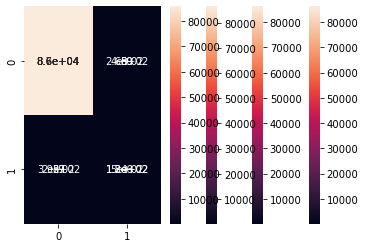

In [88]:
from sklearn.metrics import f1_score
import seaborn as sns
print(prediction.shape)
probs=torch.sigmoid(prediction)
binary_matrix= probs[:,:]>0.5
from sklearn.metrics import confusion_matrix
probs_np=binary_matrix.cpu().numpy()
test_y_np=test_multi
cf_matrix=[]
for i in range(4):
    f1 = f1_score(test_y_np[:,i], binary_matrix[:,i])
    cf = confusion_matrix(test_y_np[:,i], probs_np[:,i])
    cf_matrix.append(cf)
    print(cf)
    print('F1 score:',f1)
    sns.heatmap(cf_matrix[i], annot=True)

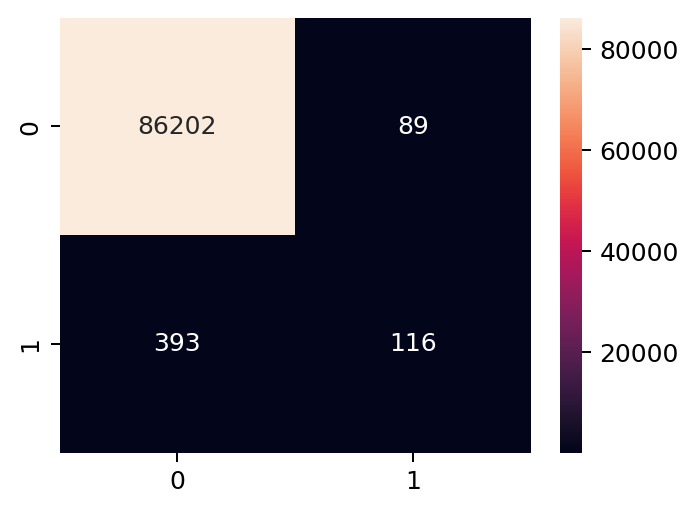

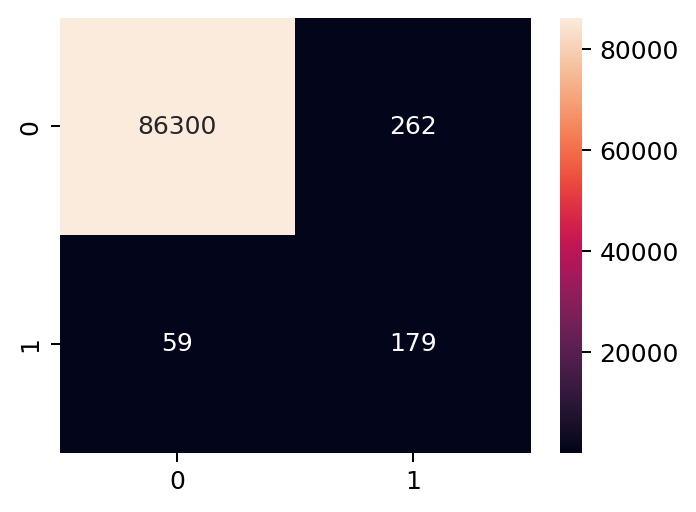

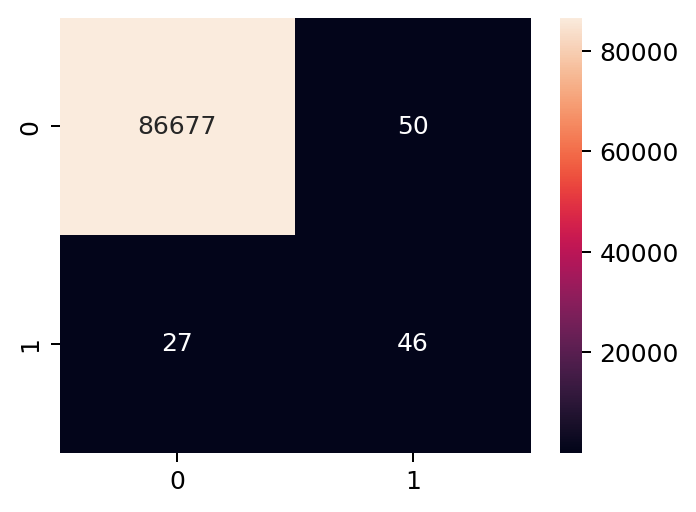

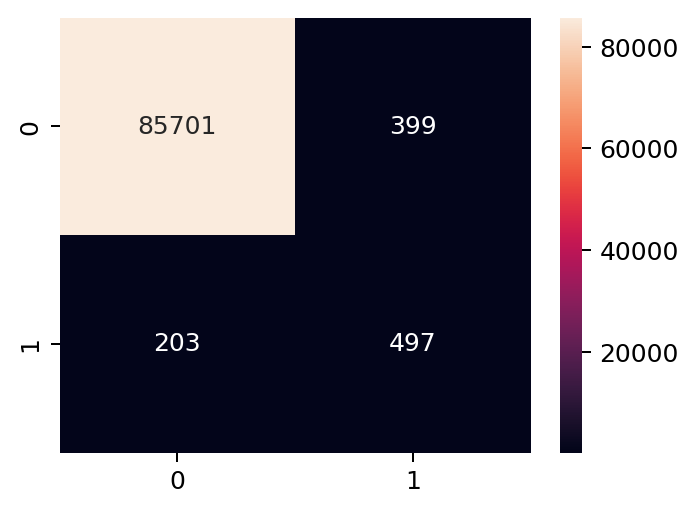

In [89]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
Path_folder = '../Multilabel_classification/result_img/report/fault_3_5_oneday'
create_directory(Path_folder)
for i in range(4):
    f, ax = plt.subplots(figsize=(4, 3),dpi = 180)
    plt.tight_layout()
    sns.heatmap(cf_matrix[i],  annot=True,fmt=".0f")
    plt.savefig(Path(Path_folder,str(i)+'.png'))
    plt.show()

## Overall F1 and Confusion matrix

In [90]:
binary = np.mean(test_multi,axis=1)>0
binary.shape
pred_binary = np.mean(np.array(binary_matrix),axis=1)>0
print(pred_binary.shape)

(86800,)


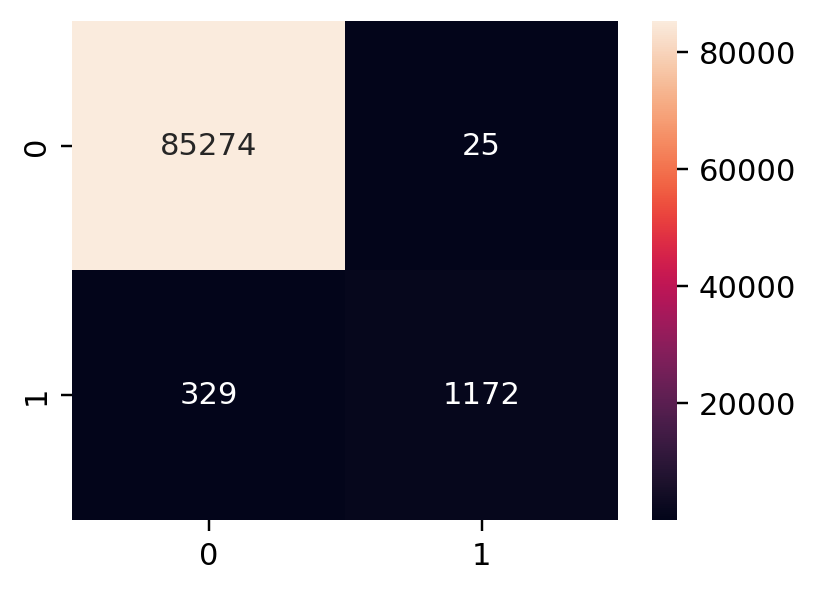

0.8687916975537434


In [91]:
cf_detection = confusion_matrix(binary, pred_binary)
cf_detection
plt.figure(figsize=(4, 3),dpi = 220)
f1_detection = f1_score(binary, pred_binary)
sns.heatmap(cf_detection,  annot=True,fmt=".0f")
plt.savefig(Path(Path_folder,'overall_detection.png'))
plt.show()
print(f1_detection)